Първо започвам с User-User и Item-Item CF

In [2]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn import cross_validation as cv

In [3]:
ml_df = pd.read_csv('datasets/ml-1m/ratings.dat', sep='::',names=["userId", "itemId", "rating", "timestamp"], engine='python')

print("users=" ,len(ml_df["userId"].unique()))
print("items=" ,len(ml_df["itemId"].unique()))
print("ratings=", len(ml_df))

users= 6040
items= 3706
ratings= 1000209


In [4]:
ml_df.head()

,userId,itemId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Да създадем матрицата User-Item

In [6]:
n_users_ml = ml_df["userId"].unique().shape[0]
#some itemIds are missing so I use max because there are higher values for ids than there are unique ids
n_items_ml = ml_df["itemId"].max()

In [4]:
def build_matrix(n_users, n_items, df):
    matrix = np.zeros((n_users, n_items))
    for uid, iid, rating, _ in df.itertuples(index=False, name=None):
        matrix[uid - 1, iid - 1] = rating
    return matrix

In [8]:
train_data, test_data = cv.train_test_split(ml_df, test_size=0.25)

In [9]:
tuple(ml_df.itertuples(index=False, name=None))[0]

(1, 1193, 5, 978300760)

In [10]:
ml_mat_train = build_matrix(n_users_ml, n_items_ml, train_data)
ml_mat_test = build_matrix(n_users_ml, n_items_ml, test_data)

In [5]:
from sklearn.metrics.pairwise import pairwise_distances

In [77]:
# similarity matrix between every user and every other user
user_similarity_cos = pairwise_distances(ml_mat_train, metric='cosine')
#similarity matrix between every item and every other item
item_similarity_cos = pairwise_distances(ml_mat_train.T, metric='cosine')
# adjust for numerical instability
eps = 1e-10
user_similarity_corel = pairwise_distances(ml_mat_train, metric='correlation')
item_similarity_corel = pairwise_distances(ml_mat_train.T, metric='correlation') + eps

In [13]:
item_similarity_cos.shape

(3952, 3952)

In [6]:
def predict_user_user(ratings_mat, similarities_mat):
    #contains the means for each user
    mean_ratings = (np.sum(ratings_mat, axis=1) / np.sum(ratings_mat != 0, axis=1)).reshape(-1, 1)
    rate_minus_mean = ratings_mat - mean_ratings
    # adjust to be closer to global mean, otherwise yields way to low of a prediction
    mean = np.sum(ratings_mat) / np.sum(ratings_mat != 0)
    pred = mean + mean_ratings + (similarities_mat @ rate_minus_mean) / np.sum(similarities_mat, axis=1).reshape(-1, 1)
    pred = np.nan_to_num(pred)
    pred[pred > 5] = 5
    pred[pred < 0] = 0
    return pred

In [7]:
def predict_item_item(ratings_mat, similarities_mat):
    # adjust to be closer to global mean, otherwise yields way to low of a prediction
    mean = np.sum(ratings_mat) / np.sum(ratings_mat !=0)
    pred = mean + (ratings_mat @ similarities_mat) / np.sum(similarities_mat, axis=1)
    pred = np.nan_to_num(pred)
    pred[pred > 5] = 5
    pred[pred < 0] = 0
    return pred

In [80]:
predicted_user_cos = predict_user_user(ml_mat_train, user_similarity_cos)
predicted_item_cos = predict_item_item(ml_mat_train, item_similarity_cos)

In [78]:
predicted_user_corel = predict_user_user(ml_mat_train, user_similarity_corel)
predicted_item_corel = predict_item_item(ml_mat_train, item_similarity_corel)

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [8]:
def rmse(prediction, real_values):
    # only predict for the ones we have info for
    prediction = prediction[real_values > 0].flatten()
    real_values = real_values[real_values > 0].flatten()
    return sqrt(mean_squared_error(prediction, real_values))

In [20]:
ml_mat_train.shape

(6040, 3952)

In [21]:
np.count_nonzero(ml_mat_train) / (ml_mat_train.shape[0] * ml_mat_train.shape[1])

0.03142662278467437

Матрицата е доста sparse, само 3% от клетките имат стойност

Да видим каква точност има при използване на косинусова мярка

In [81]:
print("RMSE, cos similarity user-user {0}: ".format(rmse(predicted_user_cos, ml_mat_test)))

RMSE, cos similarity user-user 1.0281190075203948: 


In [82]:
print("RMSE, cos similarity item-item {0}: ".format(rmse(predicted_item_cos, ml_mat_test)))

RMSE, cos similarity item-item 1.1713039998829857: 


И сега при използване на корелация.

In [79]:
print("RMSE, corel similarity user-user {0}: ".format(rmse(predicted_user_corel, ml_mat_test)))
print("RMSE, corel similarity item-item {0}: ".format(rmse(predicted_item_corel, ml_mat_test)))

RMSE, corel similarity user-user 1.0294121757208563: 
RMSE, corel similarity item-item 1.1809365719690117: 


С косинусова мярка резултатът е малко по-добър.

Да опитаме да предричаме само с top k най близки съседи

In [61]:
ml_mat_train

array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [10]:
def predict_user_user_top_k(ratings_mat, similarities_mat, k):
    n_users = similarities_mat.shape[0]
    # mark the non top k with zeros
    lowest_n_minus_k_idxs = np.argsort(similarities_mat, axis=1)[:, range(0, n_users-k)]
    row_idx = np.array([[i] * (n_users-k) for i in range(n_users)])
    top_k_sims = similarities_mat.copy()
    top_k_sims[row_idx, lowest_n_minus_k_idxs] = 0
    mean_ratings = (np.sum(ratings_mat, axis=1) / np.sum(ratings_mat != 0, axis=1)).reshape(-1, 1)
    rate_minus_mean = ratings_mat - mean_ratings
    mean = np.sum(ratings_mat) / np.sum(ratings_mat != 0)
    pred = mean + mean_ratings + (top_k_sims @ rate_minus_mean) / np.sum(top_k_sims, axis=1).reshape(-1, 1)
    pred[pred > 5] = 5
    pred[pred < 0] = 0
    return pred


In [165]:
predicted_user_cos_top_k = predict_user_user_top_k(ml_mat_train, user_similarity_cos, 100)

In [166]:
print("RMSE, cos similarity user-user top k {0}: ".format(rmse(predicted_user_cos_top_k, ml_mat_test)))

RMSE, cos similarity user-user top k 1.037867862055211: 


In [93]:
def find_best_k():
    ks = [10, 20, 50, 100, 150, 200, 500, 1000]
    errors = []
    for k in ks:
        print("k={0}".format(k))
        prediction = predict_user_user_top_k(ml_mat_train, user_similarity_cos, k)
        errors.append(rmse(prediction, ml_mat_test))
    return ks, errors

In [94]:
ks, errors = find_best_k()

k=10
k=20
k=50
k=100
k=150
k=200
k=500
k=1000


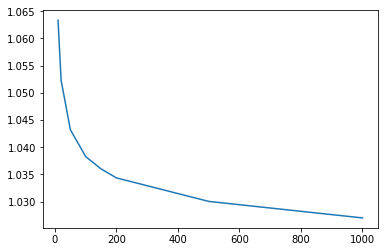

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ks, errors)
plt.show()

Грешката се влоши и клони към грешката без използване на топ к, при k -> броя потребители.

Време е да опитаме с SVD

In [53]:
from surprise import Dataset
from surprise import Reader

In [56]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ml_df[["userId", "itemId", "rating"]], reader)

trainset, testset = train_test_split(data, test_size=.25)

In [46]:
from surprise import accuracy

In [56]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8799


0.87991576132204685

In [91]:
import math
factors = [100, 150, 200]
epochs = [20, 30]
learning_rates = [0.001, 0.005, 0.01]
regularization = [0.02, 0.01, 0.001, 0.0001]

def tune_parameters():
    best_err = math.inf
    best_params = ()
    for n_factors in factors:
        for epoch in epochs:
            for lr in learning_rates:
                for reg in regularization:
                    svd = SVD(n_factors=n_factors, n_epochs=epoch, lr_all=lr, reg_all=reg)
                    svd.fit(trainset)
                    pred = svd.test(testset)
                    err = accuracy.rmse(pred, verbose=False)
                    print("factors={0}, epochs={1}, lr={2}, reg={3}, err={4}".format(n_factors, epoch, lr, reg, err))
                    if err < best_err:
                        best_err = err
                        best_params = (n_factors, epoch, lr, reg)
    print("Best params = {0}, with err={1}".format(best_params, best_err))
    return best_params

In [92]:
n_factors, epochs, lr, reg = tune_parameters()

factors=100, epochs=20, lr=0.001, reg=0.02, err=0.9184490802328459
factors=100, epochs=20, lr=0.001, reg=0.01, err=0.9183701865364304
factors=100, epochs=20, lr=0.001, reg=0.001, err=0.9198124673272483
factors=100, epochs=20, lr=0.001, reg=0.0001, err=0.9201509299828268
factors=100, epochs=20, lr=0.005, reg=0.02, err=0.8795758573122385
factors=100, epochs=20, lr=0.005, reg=0.01, err=0.8973673816366518
factors=100, epochs=20, lr=0.005, reg=0.001, err=0.9294137311787193
factors=100, epochs=20, lr=0.005, reg=0.0001, err=0.9341911792033153
factors=100, epochs=20, lr=0.01, reg=0.02, err=0.9018856741475205
factors=100, epochs=20, lr=0.01, reg=0.01, err=0.940501470750362
factors=100, epochs=20, lr=0.01, reg=0.001, err=0.9978890017855114
factors=100, epochs=20, lr=0.01, reg=0.0001, err=1.0057402883851339
factors=100, epochs=30, lr=0.001, reg=0.02, err=0.9126205410452419
factors=100, epochs=30, lr=0.001, reg=0.01, err=0.9135481181104292
factors=100, epochs=30, lr=0.001, reg=0.001, err=0.9124349

Най-добрите параметри, които откри са default-ните...

In [58]:
from surprise import SVDpp

In [60]:
algo = SVDpp(random_state=1)
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8657


0.86572917620925005

Има малко подобрение в грешката, но SVDpp се обучава много по-бавно от SVD(горното отне към 1 час), затова ще търся по-добри параметри на малка част от dataset-a.

In [108]:
reader = Reader(rating_scale=(1, 5))
first_10k = ml_df[["userId", "itemId", "rating"]].head(10000)

data_cut = Dataset.load_from_df(first_10k, reader)

trainset_cut, testset_cut = train_test_split(data_cut, test_size=.15)

In [109]:
algo = SVDpp()
algo.fit(trainset_cut)
predictions = algo.test(testset_cut)

# Baseline
accuracy.rmse(predictions)

RMSE: 0.9771


0.97714507940502227

In [117]:
algo20 = SVDpp(n_factors=20, random_state=1)
algo50 = SVDpp(n_factors=50, random_state=1)
algo100 = SVDpp(n_factors=100, random_state=1)
algo20.fit(trainset_cut)
algo50.fit(trainset_cut)
algo100.fit(trainset_cut)

predictions20 = algo20.test(testset_cut)
predictions50 = algo50.test(testset_cut)
predictions100 = algo100.test(testset_cut)


# Baseline
print("factors 20, err={0}".format(accuracy.rmse(predictions20)))
print("factors 50, err={0}".format(accuracy.rmse(predictions50)))
print("factors 100, err={0}".format(accuracy.rmse(predictions100)))

RMSE: 0.9763
factors 20, err=0.976313116506056
RMSE: 0.9816
factors 50, err=0.9816344495818357
RMSE: 0.9850
factors 100, err=0.985022352891376


Както и при SVD увеличаването на факторите не подобрява резултатите.

In [119]:
algo20 = SVDpp(n_epochs=20, random_state=1)
algo50 = SVDpp(n_epochs=50, random_state=1)
algo100 = SVDpp(n_epochs=100, random_state=1)
algo20.fit(trainset_cut)
algo50.fit(trainset_cut)
algo100.fit(trainset_cut)

predictions20 = algo20.test(testset_cut)
predictions50 = algo50.test(testset_cut)
predictions100 = algo100.test(testset_cut)


# Baseline
print("epochs 20, err={0}".format(accuracy.rmse(predictions20)))
print("epochs 50, err={0}".format(accuracy.rmse(predictions50)))
print("epochs 100, err={0}".format(accuracy.rmse(predictions100)))

RMSE: 0.9763
epochs 20, err=0.976313116506056
RMSE: 1.0110
epochs 50, err=1.0109594498218184
RMSE: 1.0296
epochs 100, err=1.0295813888960965


Изглежда няма нужда от повече от 20 епохи

In [120]:
def tune_svdpp():
    lrs = [0.001, 0.01, 0.0001]
    regs = [0.01, 0.001, 0.1]
    best_err = math.inf
    best_params = ()
    for lr in lrs:
        for reg in regs:
            algo = SVDpp(lr_all=lr, reg_all=reg, random_state=1)
            algo.fit(trainset_cut)
            pred = algo.test(testset_cut)
            err = accuracy.rmse(pred, verbose=False)
            print("lr={0}, reg={1}, err={2}".format(lr, reg, err))
            if err < best_err:
                best_err = err
                best_params = (lr, reg)
    print("Best params = {0}, with err={1}".format(best_params, best_err))
    return best_params

In [121]:
best_params_svdpp = tune_svdpp()

lr=0.001, reg=0.01, err=1.0009845099137615
lr=0.001, reg=0.001, err=1.0006390285241311
lr=0.001, reg=0.1, err=1.0015210593459711
lr=0.01, reg=0.01, err=0.9989414684628604
lr=0.01, reg=0.001, err=1.0248634359057665
lr=0.01, reg=0.1, err=0.969099775881959
lr=0.0001, reg=0.01, err=1.0426879454080984
lr=0.0001, reg=0.001, err=1.0426032595928842
lr=0.0001, reg=0.1, err=1.0435378934543684
Best params = (0.01, 0.1), with err=0.969099775881959


In [130]:
algo = SVDpp(lr_all=0.01, reg_all=0.1, random_state=1)
algo.fit(trainset_cut)
predictions = algo.test(testset_cut)


accuracy.rmse(predictions)

RMSE: 0.9691


0.96909977588195895

Отново не открих по-добри параметри

In [137]:
algo = SVDpp(lr_all=0.01, reg_all=0.1, random_state=1)
algo.fit(trainset_cut)
predictions = algo.test(testset_cut)

accuracy.rmse(predictions)

RMSE: 0.9691


0.96909977588195895

Да пуснем на целия dataset.

In [59]:
algo = SVDpp(lr_all=0.01, reg_all=0.1, random_state=1)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8794


0.87943174651128331

Да видим как се справят алгоритмите и на другия dataset.

In [11]:
data_jester = Dataset.load_builtin('jester')

In [12]:
jester_df = pd.DataFrame(data_jester.raw_ratings)

In [13]:
jester_df = jester_df.apply(pd.to_numeric, errors='ignore')

In [14]:
jester_df.columns = ["userId", "jokeId", "rating", "missing"]

In [17]:
len(jester_df)

1761439

Нямам достатъчно памет за да създам матриците на подобност за целия dataset, затова ще го направя само за част.

In [15]:
jester_df_short = jester_df.head(100000)

In [16]:
train_data_jester, test_data_jester = cv.train_test_split(jester_df_short, test_size=0.25)

In [17]:
n_users_js = jester_df_short["userId"].max()
#some jokeIds are missing so I use max because there are higher values for ids than there are unique ids
n_items_js = jester_df_short["jokeId"].max()
js_mat_train = build_matrix(n_users_js, n_items_js, train_data_jester)
js_mat_test = build_matrix(n_users_js, n_items_js, test_data_jester)

In [18]:
eps = 1e-10
# similarity matrix between every user and every other user
user_similarity_cos_js = pairwise_distances(js_mat_train, metric='cosine') + eps
#similarity matrix between every item and every other item 
item_similarity_cos_js = pairwise_distances(js_mat_train.T, metric='cosine') + eps

user_similarity_corel_js = pairwise_distances(js_mat_train, metric='correlation') + eps
item_similarity_corel_js = pairwise_distances(js_mat_train.T, metric='correlation') + eps

In [19]:
predicted_user_cos_js = predict_user_user(js_mat_train + eps, user_similarity_cos_js)
predicted_item_cos_js = predict_item_item(js_mat_train + eps, item_similarity_cos_js)

In [20]:
print("RMSE, cos similarity user-user {0}: ".format(rmse(predicted_user_cos_js, js_mat_test)))

RMSE, cos similarity user-user 9.33419393432578: 


In [21]:
print("RMSE, cos similarity item-item {0}: ".format(rmse(predicted_item_cos_js, js_mat_test)))

RMSE, cos similarity item-item 9.478999258713365: 


In [22]:
predicted_user_corel_js = predict_user_user(js_mat_train + eps, user_similarity_corel_js)
predicted_item_corel_js = predict_item_item(js_mat_train + eps, item_similarity_corel_js)

In [23]:
print("RMSE, corel similarity user-user {0}: ".format(rmse(predicted_user_corel_js, js_mat_test)))

RMSE, corel similarity user-user 13.446862646977548: 


In [24]:
print("RMSE, corel similarity item-item {0}: ".format(rmse(predicted_item_corel_js, js_mat_test)))

RMSE, corel similarity item-item 13.446862646977548: 


In [25]:
predicted_user_cos_js_k = predict_user_user_top_k(js_mat_train + eps, user_similarity_cos_js, 100)

In [26]:
print("RMSE, cos similarity user-user top 50 {0}: ".format(rmse(predicted_user_cos_js_k, js_mat_test)))

RMSE, cos similarity user-user top 50 9.417927300352863: 


Отново няма много разлика между user-user и top k user-user.

In [44]:
trainset_js, testset_js = train_test_split(data_jester, test_size=.15)

In [47]:
algo = SVD(random_state=1)
algo.fit(trainset_js)
predictions = algo.test(testset_js)

accuracy.rmse(predictions)

RMSE: 4.5134


4.5133629218012938

SVD се справя доста по-добре.

#### В заключение:
* настройването на параметри отнема много време...(особено за SVD++)
* SVD / SVD++ се справиха доста по-добре от стандартните User-User/Item-Item CF методи, което е логично имайки предвид че SGD на практика минимизира RMSE.
* При User-User използване на подхода с най-близките к съседа не подобри резултата. Това може би се дължи на това че матрицата е доста sparse, и най-близките съседи са горе-долу толкова близки колкото и останалите съседи.
* SVD++ се тренира доста по-бавно от SVD, а разликата в грешката е от рода на (+-0.02)
* разликата между косинусова мярка и корелация при User-User е почти никаква при movielens, но при jester косинусовата се справя доста по-добре, при Item-Item резултатите винаги бяха малко по-лоши от колкото при User-User.
* Оптимизирането на параметри на subset не винаги се транслира добре върху целия (особено когато разликата в грешката е малка).